# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

The notebook pulls data from the John Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The main finding is that the doubling time of cumulative confirmed cases for countries with many cases is generally on the order of 2 days, which agrees with [this preprint](https://www.medrxiv.org/content/10.1101/2020.02.05.20020750v3.full.pdf) analyzing the growth of cases in provinces in China.

The notebook is updated every evening Eastern Time.

## Important Caveats:
- This analysis uses data on the confirmed cases as reported by countries, which is different from the actual number of cases in each country (many of which are not tested). 
- Confirmed cases and actual cases in the population grow at different rates. E.g. if a country suddenly ramps up testing, the number of confirmed cases will rapidly rise, but the actual cases may not be rising as fast.
- Since we're using the entire timeline to infer the doubling times, **these values are not typically the current or most recent doubling times**. For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as Mainland China), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the initial exponential stage of the epidemic (i.e., in the past).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

In [3]:
for index, row in df.iterrows():
    if row['Country/Region'] == 'Others':
        a = row['Province/State']
        df.loc[index, 'Country/Region'] = a

## Global COVID-19 Analysis

In [4]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/9/20


,3/9/20
Country/Region,
Mainland China,80735
Italy,9172
South Korea,7478
Iran,7161
France,1209
Germany,1176
Spain,1073
Diamond Princess cruise ship,696
US,605


## Curve Fitting Global COVID-19 Cases

In [5]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        ldoubletime = np.log(2)/lpopt[1]
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit **\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time: ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        edoubletime = np.log(2)/epopt[1]
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Curve Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time: ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if logisticr2 > expr2:
            return [ldoubletime, ldoubletimeerror]
        else:
            return [edoubletime, edoubletimeerror]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror]



Mainland China

** Based on Logistic Fit **

	R^2: 0.994472352487
	Doubling Time:  3.23 (± 0.32 ) days


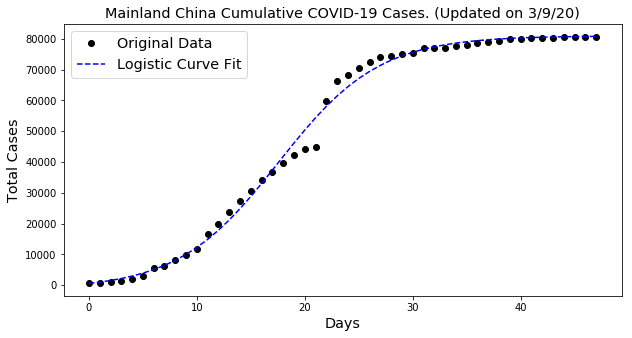



Italy

** Based on Logistic Fit **

	R^2: 0.998834991626
	Doubling Time:  2.84 (± 0.2 ) days

** Based on Exponential Curve Fit **

	R^2: 0.998556409746
	Doubling Time:  3.13 (± 0.08 ) days


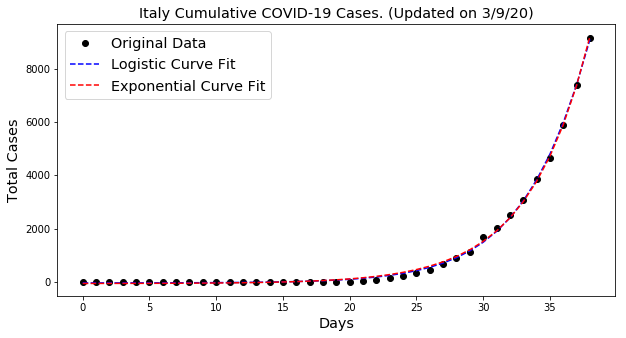



South Korea

** Based on Logistic Fit **

	R^2: 0.999468353663
	Doubling Time:  1.95 (± 0.06 ) days

** Based on Exponential Curve Fit **

	R^2: 0.958219934821
	Doubling Time:  5.35 (± 0.74 ) days


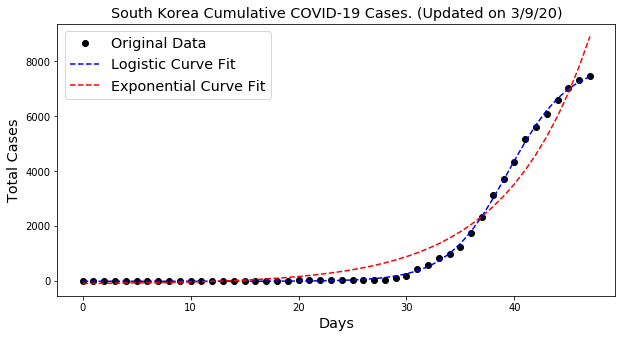



Iran

** Based on Logistic Fit **

	R^2: 0.99849575233
	Doubling Time:  1.59 (± 0.16 ) days

** Based on Exponential Curve Fit **

	R^2: 0.972720406795
	Doubling Time:  2.98 (± 0.6 ) days


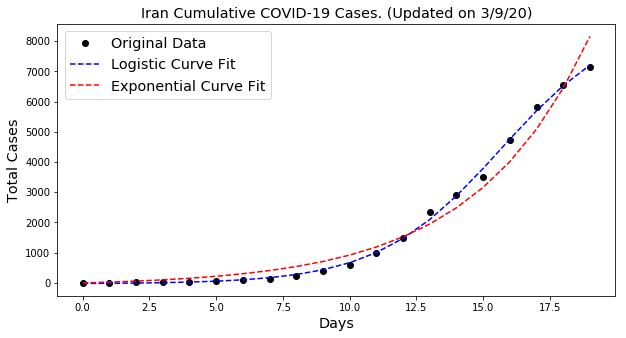



France

** Based on Exponential Curve Fit **

	R^2: 0.97850751186
	Doubling Time:  2.54 (± 0.23 ) days


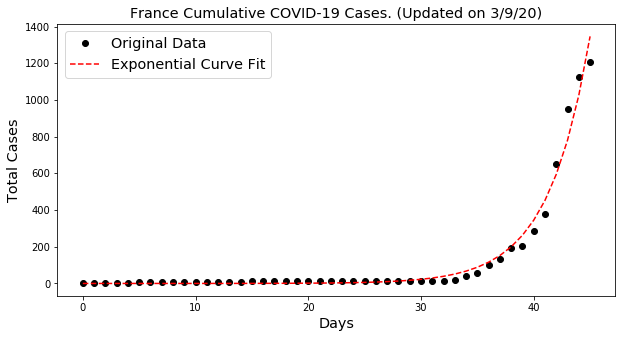



Germany

** Based on Exponential Curve Fit **

	R^2: 0.985694434763
	Doubling Time:  2.57 (± 0.2 ) days


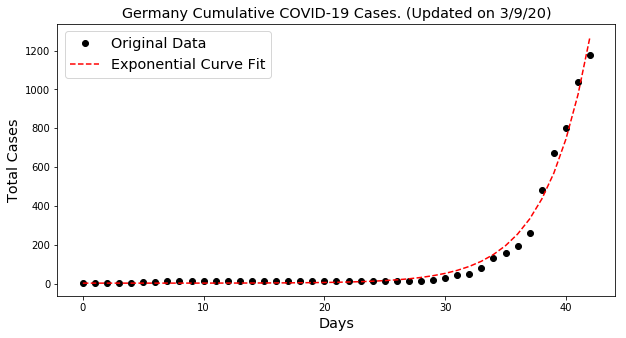



Spain

** Based on Exponential Curve Fit **

	R^2: 0.994632007474
	Doubling Time:  2.06 (± 0.1 ) days


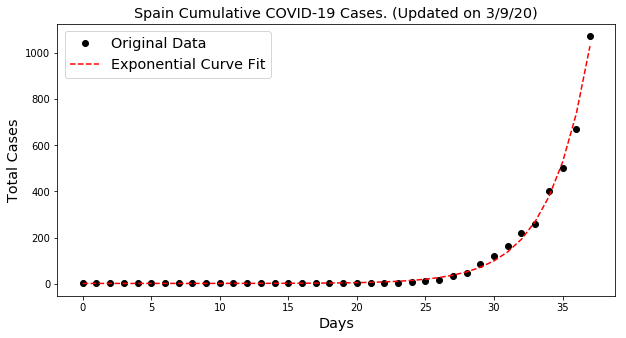



Diamond Princess cruise ship

** Based on Logistic Fit **

	R^2: 0.995285013951
	Doubling Time:  1.36 (± 0.16 ) days


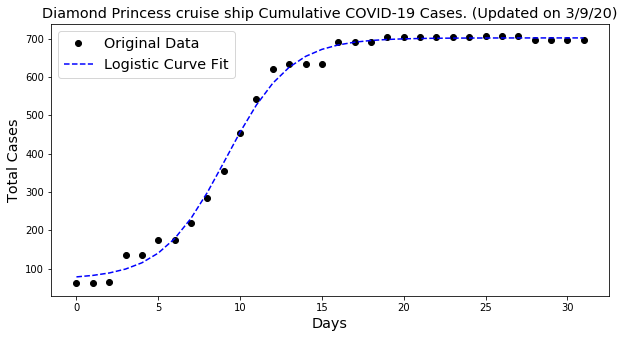



US

** Based on Exponential Curve Fit **

	R^2: 0.988818775611
	Doubling Time:  2.64 (± 0.17 ) days


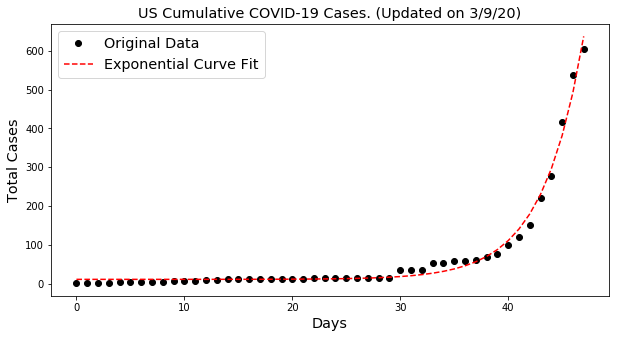



Japan

** Based on Logistic Fit **

	R^2: 0.994734543648
	Doubling Time:  6.27 (± 1.02 ) days

** Based on Exponential Curve Fit **

	R^2: 0.9940439772
	Doubling Time:  7.74 (± 0.44 ) days


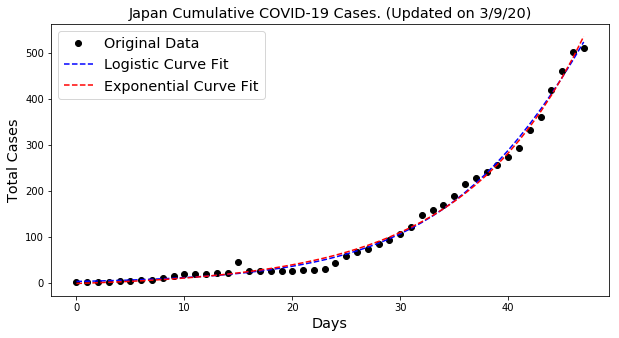



Switzerland

** Based on Logistic Fit **

	R^2: 0.995640358506
	Doubling Time:  1.11 (± 0.23 ) days

** Based on Exponential Curve Fit **

	R^2: 0.979146037435
	Doubling Time:  3.0 (± 0.78 ) days


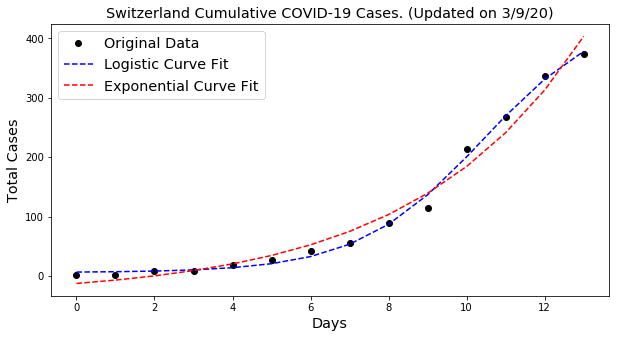



Netherlands

** Based on Logistic Fit **

	R^2: 0.999099917933
	Doubling Time:  1.05 (± 0.12 ) days

** Based on Exponential Curve Fit **

	R^2: 0.98804266666
	Doubling Time:  2.32 (± 0.48 ) days


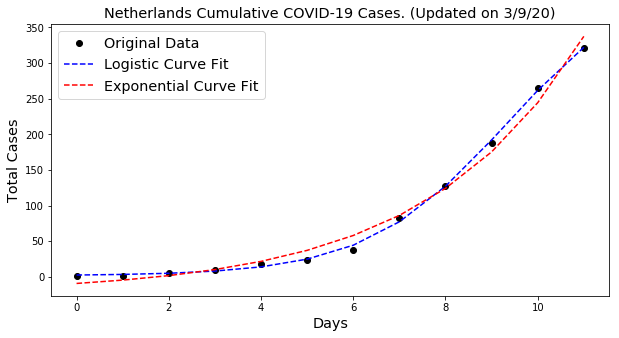



UK

** Based on Exponential Curve Fit **

	R^2: 0.992505596649
	Doubling Time:  2.48 (± 0.15 ) days


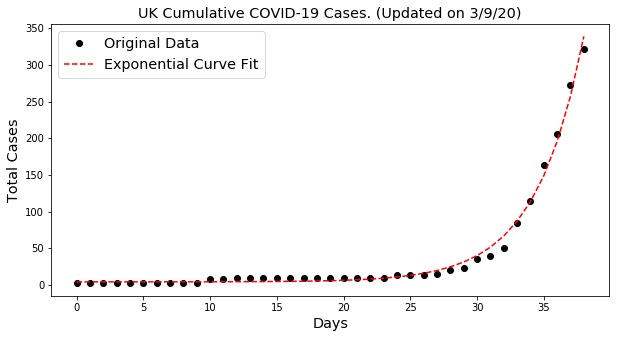



Sweden

** Based on Exponential Curve Fit **

	R^2: 0.982704615627
	Doubling Time:  2.19 (± 0.2 ) days


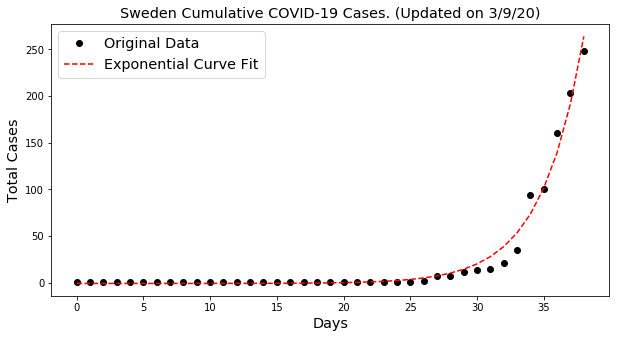



Belgium

** Based on Exponential Curve Fit **

	R^2: 0.965334120165
	Doubling Time:  2.0 (± 0.27 ) days


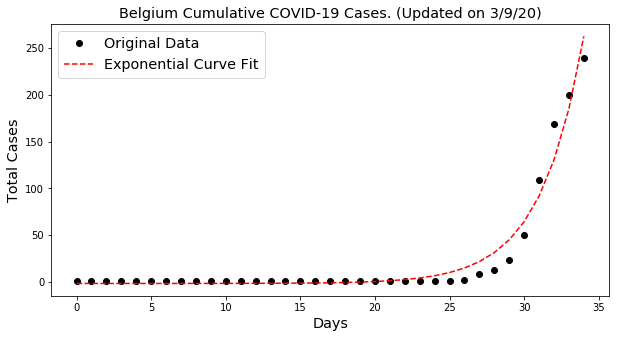



Norway

** Based on Logistic Fit **

	R^2: 0.997801932616
	Doubling Time:  1.43 (± 0.27 ) days

** Based on Exponential Curve Fit **

	R^2: 0.989498604436
	Doubling Time:  3.46 (± 0.77 ) days


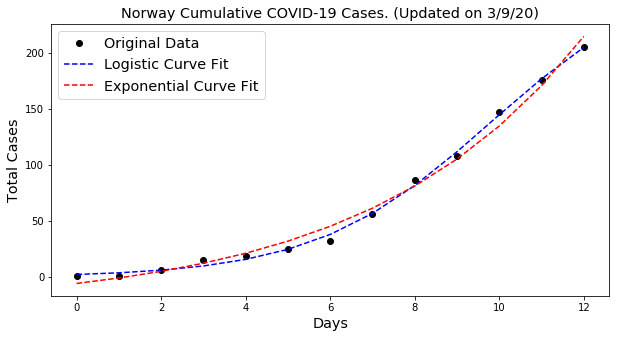



Singapore

** Based on Logistic Fit **

	R^2: 0.977894004935
	Doubling Time:  92.81 (± 3070.38 ) days

** Based on Exponential Curve Fit **

	R^2: 0.972826803498
	Doubling Time:  35.57 (± 15.25 ) days


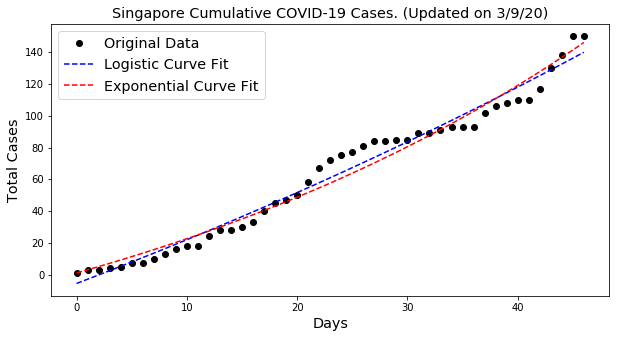



Austria

** Based on Logistic Fit **

	R^2: 0.998184841624
	Doubling Time:  1.93 (± 0.42 ) days

** Based on Exponential Curve Fit **

	R^2: 0.997394691275
	Doubling Time:  2.52 (± 0.21 ) days


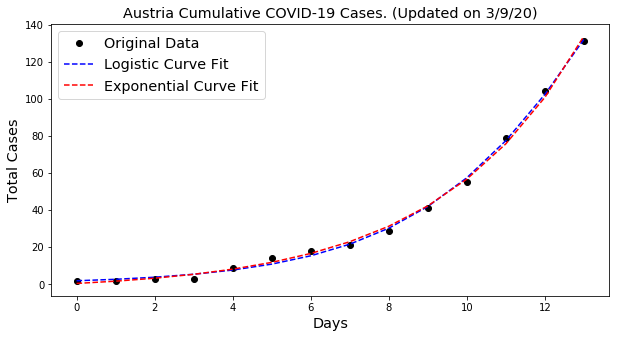



Malaysia


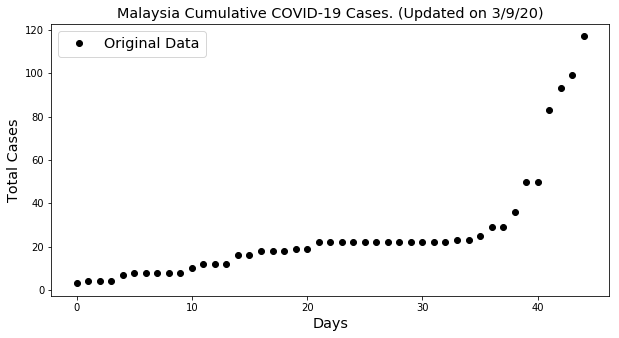



Hong Kong

** Based on Logistic Fit **

	R^2: 0.992091831065
	Doubling Time:  7.64 (± 1.64 ) days

** Based on Exponential Curve Fit **

	R^2: 0.981167229093
	Doubling Time:  39.68 (± 15.67 ) days


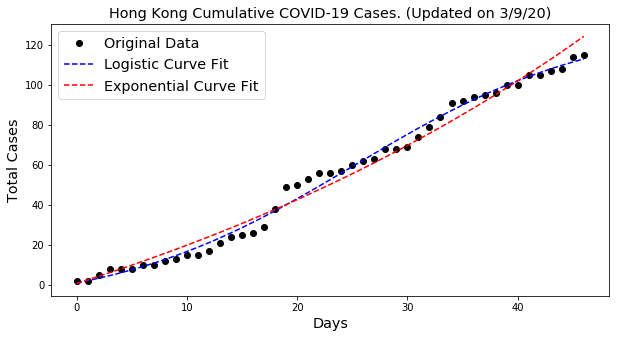

In [6]:
topcountries = cases.index
doublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

## Doubling Times for Global COVID-19 Cases

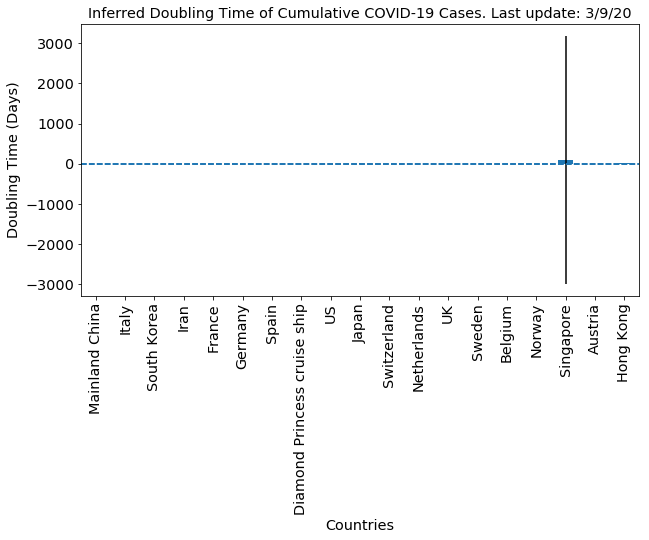

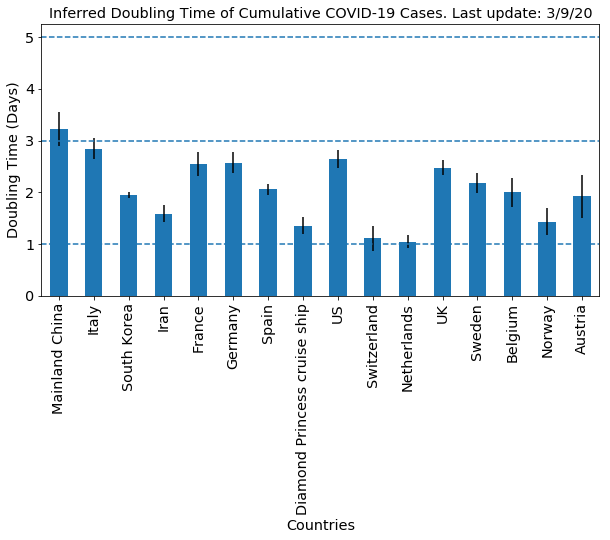

In [7]:
d = {'Countries': countries, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Doubling Time'] < 5]
dt.plot.bar(x = 'Countries', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [8]:
uscases = df[df['Country/Region'] == 'US']

uscasesbystate = uscases.copy()
uscasesbystate['Province/State'] = uscasesbystate['Province/State'].str.split(", ", expand=True)[1]

usstatesummary = uscasesbystate.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary


Number of confirmed US COVID-19 cases by state as of 3/9/20


,3/9/20
Province/State,
NY,142
WA,128
CA,104
MA,24
TX,14
FL,14
OR,12
GA,10
CO,8


In [9]:
uscitysummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = uscitysummary.columns[0]
uscitysummary = uscitysummary.sort_values(by = mostrecentdate, ascending = False)
uscitysummary = uscitysummary[uscitysummary[mostrecentdate] >= 5]

print('\nUS Locations with 5 or more confirmed cases as of', mostrecentdate)

uscitysummary


US Locations with 5 or more confirmed cases as of 3/9/20


,3/9/20
Province/State,
"Westchester County, NY",98
"King County, WA",83
Unassigned Location (From Diamond Princess),45
"Santa Clara County, CA",38
"Snohomish County, WA",31
Grand Princess Cruise Ship,21
"New York County, NY",19
"Nassau County, NY",17
"Los Angeles, CA",14


## Curve Fitting US COVID-19 Cases



US state:  NY

** Based on Logistic Fit **

	R^2: 0.996934274396
	Doubling Time:  0.91 (± 0.32 ) days

** Based on Exponential Curve Fit **

	R^2: 0.98964499065
	Doubling Time:  2.28 (± 0.77 ) days


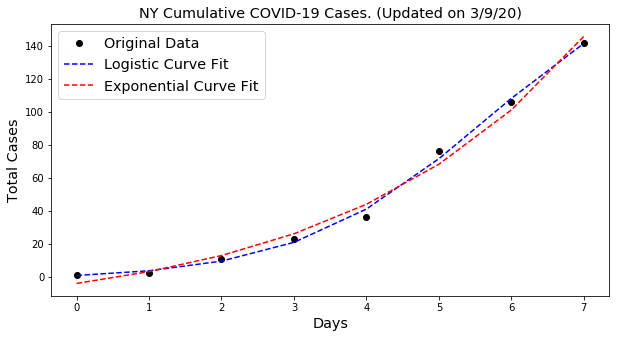



US state:  WA

** Based on Exponential Curve Fit **

	R^2: 0.963523731017
	Doubling Time:  2.81 (± 0.33 ) days


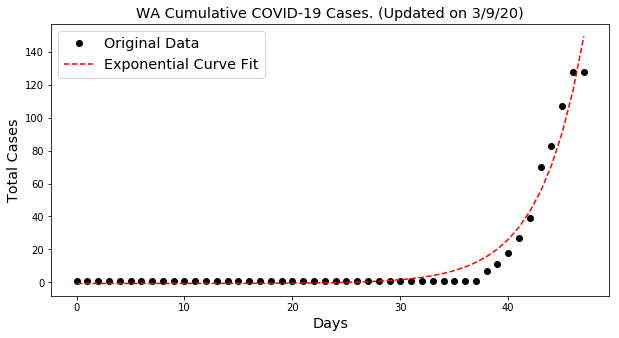



US state:  CA

** Based on Exponential Curve Fit **

	R^2: 0.977750002896
	Doubling Time:  2.82 (± 0.27 ) days


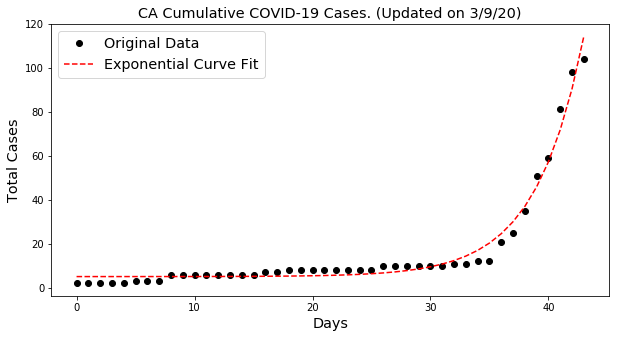

In [10]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print('\n');
doublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscasesbystate,'Province/State', state)
    if a:
        states.append(state)
        doublingtime.append(a[0])
        errors.append(a[1])
    print('\n')

## Doubling Times for US COVID-19 Cases

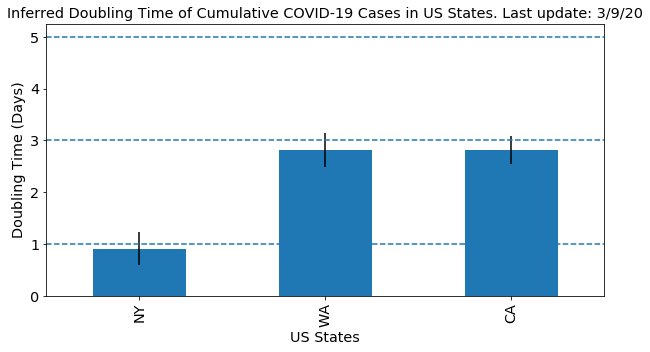

In [11]:
d = {'States': states, 'Doubling Time': doublingtime, '95%CI': errors}

print('\n')
dt = pd.DataFrame(data = d)
dt.plot.bar(x = 'States', y = 'Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()
